# Q1. dbscan.csv 파일을 Pandas를 사용해서 읽고, 인덱스를 날짜 타입으로 변환하세요(변수명은 df)

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#통계 패키지
from scipy import stats

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# 시계열 데이터
df = pd.read_csv("./data/dbscan.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227 entries, 0 to 1226
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1227 non-null   object 
 1   KOSPI        1227 non-null   float64
 2   S&P 500      1185 non-null   float64
 3   Gold         1187 non-null   float64
 4   Oil(WTI)     1187 non-null   float64
 5   US 10Y Bond  1188 non-null   float64
 6   KRW/USD      1225 non-null   float64
 7   JPY/USD      1225 non-null   float64
dtypes: float64(7), object(1)
memory usage: 76.8+ KB


In [42]:
# 컬럼 Date의 타입을 Object -> datetime으로 변환
# 판매, 세금, 성장, 공기질 데이터, 부산의 어제와 오늘, 출생률 다 시계열
# 시계열 데이터는 반드시 인덱스를 Date를 잡아야함. 그래야 shift를 넣어서 증감률을 볼 수 있음

df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227 entries, 0 to 1226
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1227 non-null   datetime64[ns]
 1   KOSPI        1227 non-null   float64       
 2   S&P 500      1185 non-null   float64       
 3   Gold         1187 non-null   float64       
 4   Oil(WTI)     1187 non-null   float64       
 5   US 10Y Bond  1188 non-null   float64       
 6   KRW/USD      1225 non-null   float64       
 7   JPY/USD      1225 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 76.8 KB


In [43]:
# X축의 독립변인이 연속으로 놓을 수 있을 경우 시계열 데이터로 취급하기도 함.

# 컬럼 Date를 인덱스로 변환 
df = df.set_index('Date') # keys='Date' 으로 써도 됨
df.head()

,KOSPI,S&P 500,Gold,Oil(WTI),US 10Y Bond,KRW/USD,JPY/USD
Date,,,,,,,
2020-05-15,1927.280029,2863.699951,1753.400024,29.430000,139.328125,1225.459961,107.364998
2020-05-18,1937.109985,2953.909912,1731.800049,31.820000,138.593750,1232.089966,107.208000
2020-05-19,1980.609985,2922.939941,1744.199951,32.500000,138.859375,1224.199951,107.380997
2020-05-20,1989.640015,2971.610107,1750.599976,33.490002,139.078125,1224.319946,107.809998
2020-05-21,1998.310059,2948.510010,1720.500000,33.919998,139.062500,1226.550049,107.591003


# Q2. 결측치가 몇개인지 확인하고, 선형 보간법과 채우기 기법을 사용해서 결측치를 처리하세요

In [44]:
df.isnull().sum()
# 결측치 에러의 갯수를 볼 수 있음.

KOSPI           0
S&P 500        42
Gold           40
Oil(WTI)       40
US 10Y Bond    39
KRW/USD         2
JPY/USD         2
dtype: int64

In [45]:
# .interpolate : 결측치를 앞뒤 데이터의 기울기를 구해서 해당 데이터를 안에 넣어 준다.
# 선형을 맞춰서 그대로 감.
# 시계열 데이터는 이것으로 가면됨.

df = df.interpolate(method='linear') # default가 linerar
df.isnull().sum()

# 맨 앞의 데이터를 체워 넣으래. 
# bfill, ffill 등으로 앞뒤를 맞추던지 해야함.

KOSPI          0
S&P 500        0
Gold           0
Oil(WTI)       0
US 10Y Bond    0
KRW/USD        0
JPY/USD        0
dtype: int64

In [46]:
# 데이터 변화가 거의 없을 것이라 생각하고, 앞의 데이터를 그대로 가져 온다.
# 안정적인 데이터에 사용 (예: 전력 사용데이터, 생활비 데이터)

# df.ffill()
# df.isnull().sum()

# Q3. 이상치 찾기

In [47]:
# 이상치를 찾는 방법
def remove_outliers(data, threshold=3):
    # -값은 큰 의미가 없음. 그래서 절대값으로 변환 
    # 단, 원래 양수가 되면 안되는 값이 모여있을 때 abs로 변환하면 큰일 남.
    z_score = stats.zscore(data)
    abs_z_score = np.abs(z_score)

    # 일반적으로 3을 넘어가면, 데이터가 평균적인 것이 아니라 튀는 값이 있는 것.
    # 3은 데이터 분석을 통해 이 데이터가 튀는 이상값인지 알 수 있어야함. (통상적으로 3을 쓰긴 함.)
    filtered_entries = (abs_z_score < 3).all(axis=1)
    return df[filtered_entries]

In [48]:
df_no_outliers = remove_outliers(df)
df_no_outliers.shape

(1204, 7)

In [49]:
df_no_outliers

,KOSPI,S&P 500,Gold,Oil(WTI),US 10Y Bond,KRW/USD,JPY/USD
Date,,,,,,,
2020-05-15,1927.280029,2863.699951,1753.400024,29.430000,139.328125,1225.459961,107.364998
2020-05-18,1937.109985,2953.909912,1731.800049,31.820000,138.593750,1232.089966,107.208000
2020-05-19,1980.609985,2922.939941,1744.199951,32.500000,138.859375,1224.199951,107.380997
2020-05-20,1989.640015,2971.610107,1750.599976,33.490002,139.078125,1224.319946,107.809998
2020-05-21,1998.310059,2948.510010,1720.500000,33.919998,139.062500,1226.550049,107.591003
...,...,...,...,...,...,...,...
2025-04-03,2486.699951,5396.520020,3097.000000,66.949997,112.640625,1466.040039,147.871994
2025-04-04,2465.419922,5074.080078,3012.000000,61.990002,113.046875,1450.680054,146.231003
2025-04-07,2328.199951,5062.250000,2951.300049,60.700001,112.062500,1458.520020,145.432999


In [50]:
# 판다스는 절대 반복문을 돌면 안됨
# 대량 데이터가 많고, 날짜가 맞지 않을 수도 있고, 판다스에서 제공되는 기능으로 사용해야 함

# 어제의 날짜로 오늘의 날짜를 나누는 것.
# 주식과 비트코인의 등락폭을 계산하는 기본 공식
# 첫 날짜는 na임으로 해당값 날림
# shift 연산자를 써서 하루차이, 1주일, 1년 등을 설정함.
returns = np.log(df_no_outliers / df_no_outliers.shift(1)).dropna()

# 숫자가 1이 포함이 되었으면, 상관관계가 높아지는 경향이 있다.
# 그래서 숫자 스케일을 log 값으로 작게 맞춰준다.

# 수익률
returns

,KOSPI,S&P 500,Gold,Oil(WTI),US 10Y Bond,KRW/USD,JPY/USD
Date,,,,,,,
2020-05-18,0.005087,0.031015,-0.012395,0.078080,-0.005285,0.005396,-0.001463
2020-05-19,0.022208,-0.010540,0.007135,0.021145,0.001915,-0.006424,0.001612
2020-05-20,0.004549,0.016514,0.003663,0.030007,0.001574,0.000098,0.003987
2020-05-21,0.004348,-0.007804,-0.017344,0.012758,-0.000112,0.001820,-0.002033
2020-05-22,-0.014202,0.002351,0.008162,-0.019950,0.000674,0.005561,0.000372
...,...,...,...,...,...,...,...
2025-04-03,-0.007676,-0.049606,-0.013757,-0.068684,0.010178,-0.002677,-0.012841
2025-04-04,-0.008594,-0.061609,-0.027830,-0.076973,0.003600,-0.010532,-0.011159
2025-04-07,-0.057267,-0.002334,-0.020359,-0.021029,-0.008746,0.005390,-0.005472


In [51]:
# 연관율 / KOSPI는 US 10Y Bond, KRW/USD, JPY/USD -> 상관이 없는 데이터

returns.corr()

,KOSPI,S&P 500,Gold,Oil(WTI),US 10Y Bond,KRW/USD,JPY/USD
KOSPI,1.000000,0.172809,0.095710,0.108023,-0.039549,-0.227364,-0.039115
S&P 500,0.172809,1.000000,0.127916,0.213356,0.030067,0.004462,0.038287
Gold,0.095710,0.127916,1.000000,0.158151,0.322277,-0.052023,-0.016027
Oil(WTI),0.108023,0.213356,0.158151,1.000000,-0.134845,0.002872,-0.018639
US 10Y Bond,-0.039549,0.030067,0.322277,-0.134845,1.000000,-0.075953,-0.053213
KRW/USD,-0.227364,0.004462,-0.052023,0.002872,-0.075953,1.000000,0.361346
JPY/USD,-0.039115,0.038287,-0.016027,-0.018639,-0.053213,0.361346,1.000000


# Q4. Scale 조정

In [52]:
#학습데이터를 전체 다 집어 넣는다.
scaler = RobustScaler() # 일반적으로는 Standard 쓰는게 나음
scaler_returns = scaler.fit_transform(returns)

# Q5. K-Means의 K를 찾아보자!

In [53]:
# y가 없음 / silhouette를 같은 통계치를 활용하는 통계치를 평가하는 모델이 사이키런에 있다. 그래서 이것을 활용한다. 
# 이렇게 해야 k값을 전문적으로 쓸 수 있음

inertia =[]
silhouette_scores =[]
k_range = range(2, 10)

for k in k_range:
    # KMeas 매개변수를 설정 (클러스터 분류 수, 초기 중심지 시도 횟수(티폴트 10, 클러스터의 최적의 중심 위치 찾기 위해 반복하는 수), 시드값)
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaler_returns)
    
    kmeans_lables = kmeans.labels_
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaler_returns, kmeans_lables)) #silhouette_score는 값이 큰 것이 중요함.
    # 예측
    # silhousette_scores를 측정
    # k값이 중요!

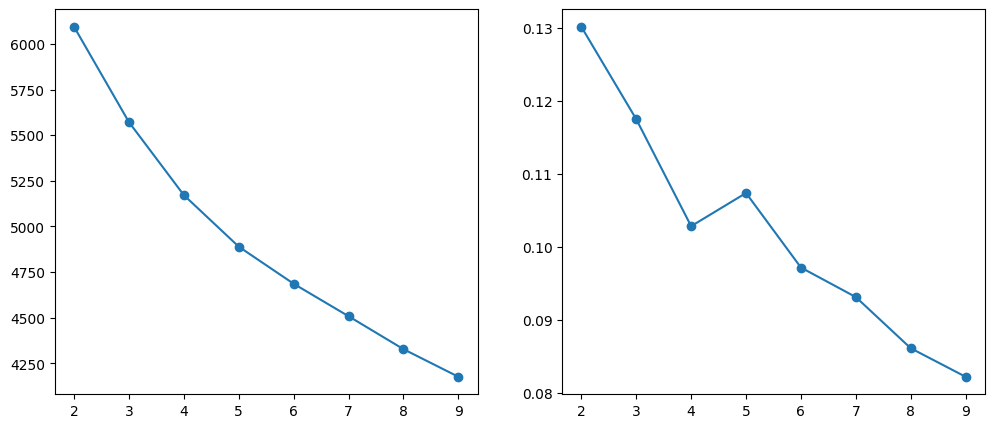

In [54]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, "o-")
# 5가 젤 좋음

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, "o-")
plt.show()

# Q6. DBSCAN

In [55]:
eps_range = np.arange(0.3, 1.5, 0.1)
min_sample_range = [3, 5, 7, 10]
best_silhouette = -1
best_eps = 0
best_min_sampled = 0

In [56]:
for eps in eps_range:
    for min_samples in min_sample_range:
        ## DBSCAN 군집기 설정
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(scaler_returns)
        # 최소한 클러스터는 1개 이상, 모든 포인트가 -1이 아니였응면 좋겠음 / -1은 노이즈 값임
        
        # 우선은 노이즈 값을 다 빼고 k값을 보자. 나중에 노답이면 노이즈를 다 끌어 안을 건데, 우선은 k를 보자.
        n_cluster = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        
        # 답안을 모를 때 노이즈가 노이즈인 것이지, 우리는 비지도 학습을 하는데, 어떻게 노이즈인줄 아니..
        n_cluster = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        if n_cluster > 1 and np.sum(dbscan_labels != -1) > 10:
            non_noise_idx = dbscan_labels != -1
            if np.sum(non_noise_idx) >1:
                score = silhouette_score(scaler_returns[non_noise_idx], dbscan_labels[non_noise_idx])
                #min_max 찾는 알고리즘
                if score > best_silhouette:
                    best_silhouette = score
                    best_eps = eps
                    best_min_sampled = min_samples

In [57]:
print(best_silhouette, best_eps, best_min_sampled)

0.3520712827086478 0.5 3


In [58]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans_lables = kmeans.fit_predict(scaler_returns)

In [59]:
dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan_labels = dbscan.fit_predict(scaler_returns)

In [60]:
# PCA에게 x, y 축을 2개로 나눠 달라 함.
pca = PCA(n_components=2)
pca_comp = pca.fit_transform(scaler_returns)

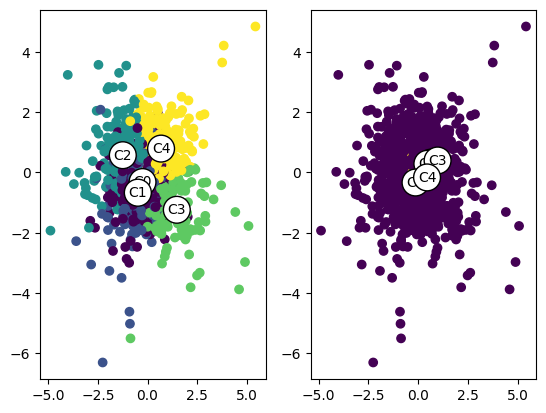

In [61]:
plt.subplot(1, 2, 1)
plt.scatter(pca_comp[: , 0], pca_comp[:, 1], c=kmeans_lables)

for i in range(5):
    mask = kmeans_lables == i
    center = np.mean(pca_comp[mask], axis=0)
    plt.annotate(
        f"C{i}",
        xy=center,
        ha="center",
        va="center",
        bbox=dict(boxstyle="circle", fc="white", ec="black")
    )

plt.subplot(1, 2, 2)
plt.scatter(pca_comp[: , 0], pca_comp[:, 1], c=dbscan_labels)
for i in range(5):
    mask = dbscan_labels == i
    center = np.mean(pca_comp[mask], axis=0)
    plt.annotate(
        f"C{i}",
        xy=center,
        ha="center",
        va="center",
        bbox=dict(boxstyle="circle", fc="white", ec="black")
    )

비지도는 답안이 없어서 사람이 해당 분석을 보고 결과값을 설명할 수 있어야 한다.

In [62]:
returns_with_labels = returns.copy()
returns_with_labels["KMeans"] = kmeans_lables
returns_with_labels["DBSCAN"] = dbscan_labels

In [ ]:
# KMeans의 DB 내적 정보
returns_with_labels.groupby("KMeans").mean()

# DBSCAN의 DB 내적 정보
returns_with_labels.groupby("DBSCAN").mean()

,KOSPI,S&P 500,Gold,Oil(WTI),US 10Y Bond,KRW/USD,JPY/USD,KMeans
DBSCAN,,,,,,,,
-1,0.000026,0.000493,0.000414,0.000401,-0.000194,0.000213,0.000274,1.974892
0,0.002012,0.003374,0.009178,-0.002534,0.000688,-0.002059,0.000898,4.000000
1,0.004873,0.004749,0.002658,0.013183,-0.001793,-0.002737,0.000234,2.666667
2,0.001218,0.001889,-0.007241,-0.001028,0.001163,0.001410,-0.001701,0.000000
3,0.017983,0.001337,0.006879,0.013891,0.000320,-0.001544,-0.000101,4.000000
4,0.009105,-0.001928,0.002670,-0.002719,0.001595,-0.000075,-0.001053,4.000000
5,0.004461,0.001706,0.001343,0.006936,0.000276,-0.004010,-0.003572,2.500000
6,-0.000817,-0.000540,0.000057,0.012363,-0.000679,-0.000385,-0.002829,1.142857
7,0.003021,-0.001120,0.000964,0.007436,-0.000527,-0.003469,0.000954,0.000000


In [64]:
# Backtesting

risk_free_rate = 0.02 /252 # 연 2% 무위혐 이자율

# 샤프 지수
def caclulate_sharpe_ratio(returns_df, risk_free_rate=risk_free_rate, period=252):
    excess_returns = returns_df - risk_free_rate
    mean_excess_returns = excess_returns.mean() * period
    std_dev = returns_df.std() * np.sqrt(period)
    # 샤프 지수 = 초과 수익률 / 표준편차
    return mean_excess_returns / std_dev

In [65]:
# 0인 클러스터를 가져와 보세요. 마스킹 아니고 필터링
# returns_with_labels[returns_with_labels["KMeans"] == 0]

In [66]:
kMeans_sharpe_ratios = {}
for cluster in range(5):
    cluster_returns = returns_with_labels[returns_with_labels["KMeans"] == cluster].drop(["KMeans", "DBSCAN"], axis=1)
    sharpe_rations = caclulate_sharpe_ratio(cluster_returns)
    kMeans_sharpe_ratios[cluster] = sharpe_rations

In [67]:
sharpe_df = pd.DataFrame(kMeans_sharpe_ratios)
sharpe_df

,0,1,2,3,4
KOSPI,5.775269,-5.422850,-12.996984,1.550186,6.249705
S&P 500,1.694235,-9.101540,-5.367742,-1.874186,10.641221
Gold,-12.445096,-1.348436,-3.394389,9.674703,17.276710
Oil(WTI),4.118623,-20.827990,2.686658,-0.676243,9.419849
US 10Y Bond,-16.078890,11.833198,-9.151028,8.438936,4.823254
KRW/USD,-5.865286,2.694839,19.984248,-18.116128,2.041768
JPY/USD,-3.319237,2.191920,15.994491,-24.350169,4.883377


In [68]:
sharpe_df.mean()

0   -3.731483
1   -2.854408
2    1.107893
3   -3.621843
4    7.905126
dtype: float64